In [8]:
!pip install --quiet --upgrade tensorflow-federated-nightly
!pip install --quiet --upgrade nest-asyncio
!pip install --quiet --upgrade tb-nightly  

import nest_asyncio
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import tensorflow_privacy as tfp
from matplotlib import pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-nightly 2.12.0.dev20221109 requires tb-nightly~=2.11.0.a, but you have tb-nightly 2.12.0a20221112 which is incompatible.


In [9]:
nest_asyncio.apply()

@tff.federated_computation
def start():
  return 'Federated learning + differential privacy'

start()

b'Federated learning + differential privacy'

In [10]:
train, test = tff.simulation.datasets.cifar100.load_data()

In [11]:
print("Structure type:") 
train.element_type_structure

Structure type:


OrderedDict([('coarse_label', TensorSpec(shape=(), dtype=tf.int64, name=None)),
             ('image',
              TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None)),
             ('label', TensorSpec(shape=(), dtype=tf.int64, name=None))])

In [12]:
print("Number of clients in training data") 
len(train.client_ids)

Number of clients in training data


500

In [13]:
print("Number of clients in testing data") 
len(test.client_ids)

Number of clients in testing data


100

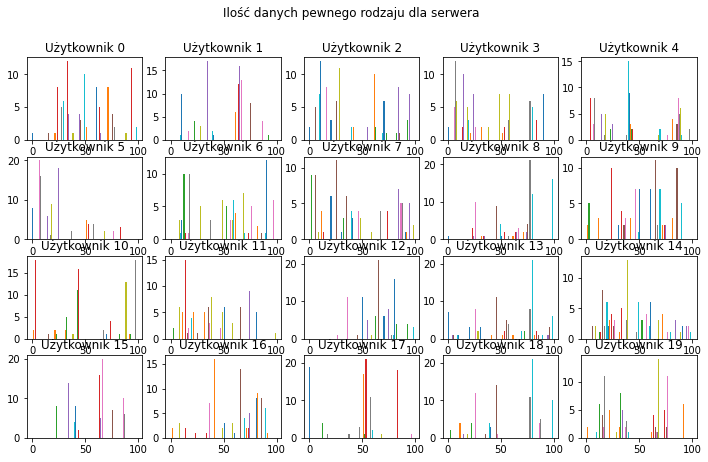

In [14]:
figure_1 = plt.figure(figsize=(12, 7))
figure_1.suptitle('Ilość danych pewnego rodzaju dla serwera')
for i in range(20):
  first_clients_data = train.create_tf_dataset_for_client(train.client_ids[i])
  plot = collections.defaultdict(list)
  for example in first_clients_data:
    label = example['label'].numpy()
    plot[label].append(label)
  plt.subplot(4, 5, i+1)
  plt.title('Użytkownik {}'.format(i))
  for number in range(100):
    plt.hist(
        plot[number],
        density=False,
        bins=list(range(0,100)))


In [15]:
def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.cifar100.load_data()

  def element_change(element):
    return collections.OrderedDict(
        x=tf.expand_dims(element['image'], -1)/255, y=element['label'])

  def train_preprocess(dataset):
    return (dataset.map(element_change)
                   .shuffle(buffer_size=418)
                   .repeat(1)
                   .batch(32, drop_remainder=False))

  def test_preprocess(dataset):
    return dataset.map(element_change).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(train_preprocess)
  emnist_test = test_preprocess(
      emnist_test.create_tf_dataset_from_all_clients())
  return emnist_train, emnist_test

emnist_train, emnist_test = get_emnist_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [16]:
emnist_train.element_type_structure

OrderedDict([('x',
              TensorSpec(shape=(None, 32, 32, 3, 1), dtype=tf.float32, name=None)),
             ('y', TensorSpec(shape=(None,), dtype=tf.int64, name=None))])

In [17]:
def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(input_shape=(32,32,3), kernel_size=(2, 2), padding='same', strides=(2,2), filters = 32),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (1,1), padding = "same"),
      tf.keras.layers.Conv2D(kernel_size=(2, 2), padding='same', strides=(2,2), filters = 64),
      tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides = (1,1), padding = "same"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation=tf.nn.relu),
      tf.keras.layers.Dense(128, activation=tf.nn.relu),
      tf.keras.layers.Dense(100, activation=tf.nn.softmax)])
  return tff.learning.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=emnist_test.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [18]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=10)

total_clients = len(emnist_train.client_ids)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  sampling_prob = clients_per_round / total_clients

  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)

  state = learning_process.initialize()
  for round in range(rounds):
    if round % 2 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [emnist_test])['eval']
      print(f'Runda {round:3d}: {metrics}')
      data_frame = data_frame.append({'Runda': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)
    x = np.random.uniform(size=total_clients)
    sampled_clients = [
        emnist_train.client_ids[i] for i in range(total_clients)
        if x[i] < sampling_prob]
    sampled_train_data = [
        emnist_train.create_tf_dataset_for_client(client)
        for client in sampled_clients]

    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [emnist_test])['eval']
  print(f'Runda {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Runda': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
def client10(noise_multiplier):
  rounds = 2
  clients_per_round = 10
  data_noise_10_clients_basic_model = pd.DataFrame()

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_10_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_10_clients_basic_model)
  print()

  return data_noise_10_clients_basic_model


In [22]:
def client30(noise_multiplier):
  data_noise_30_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 30

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_30_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_30_clients_basic_model)
  print()

  return data_noise_30_clients_basic_model

In [24]:
def client50(noise_multiplier):
  data_noise_50_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 50

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_50_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_50_clients_basic_model)
  print()

  return data_noise_50_clients_basic_model


In [26]:
def client70(noise_multiplier):
  data_noise_70_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 70

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_70_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_70_clients_basic_model)
  print()

  return data_noise_70_clients_basic_model

In [28]:
def client100(noise_multiplier):
  data_noise_100_clients_basic_model = pd.DataFrame()
  rounds = 2
  clients_per_round = 100

  print("Mnożnik szumu " + str(noise_multiplier))
  data_noise_100_clients_basic_model = train(rounds, noise_multiplier, clients_per_round, data_noise_100_clients_basic_model)
  print()

  return data_noise_100_clients_basic_model

In [21]:
buff = client10(0.0)


Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.0106), ('loss', 4.605208), ('num_examples', 10000), ('num_batches', 79)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0106), ('loss', 4.6052074), ('num_examples', 10000), ('num_batches', 79)])



In [23]:
buff = client30(0.0)


Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.0123), ('loss', 4.6051097), ('num_examples', 10000), ('num_batches', 79)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0122), ('loss', 4.60511), ('num_examples', 10000), ('num_batches', 79)])



In [25]:
buff = client50(0.0)


Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.01), ('loss', 4.605151), ('num_examples', 10000), ('num_batches', 79)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0101), ('loss', 4.6051507), ('num_examples', 10000), ('num_batches', 79)])



In [27]:
buff = client70(0.0)


Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.0115), ('loss', 4.6051245), ('num_examples', 10000), ('num_batches', 79)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0115), ('loss', 4.6051245), ('num_examples', 10000), ('num_batches', 79)])



In [29]:
buff = client100(0.0)


Mnożnik szumu 0.0
Runda   0: OrderedDict([('sparse_categorical_accuracy', 0.0104), ('loss', 4.605156), ('num_examples', 10000), ('num_batches', 79)])
Runda   2: OrderedDict([('sparse_categorical_accuracy', 0.0104), ('loss', 4.6051555), ('num_examples', 10000), ('num_batches', 79)])

